In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

from tkinter import simpledialog
from tkinter import filedialog as fd
import tkinter as tk
from tkinter import messagebox

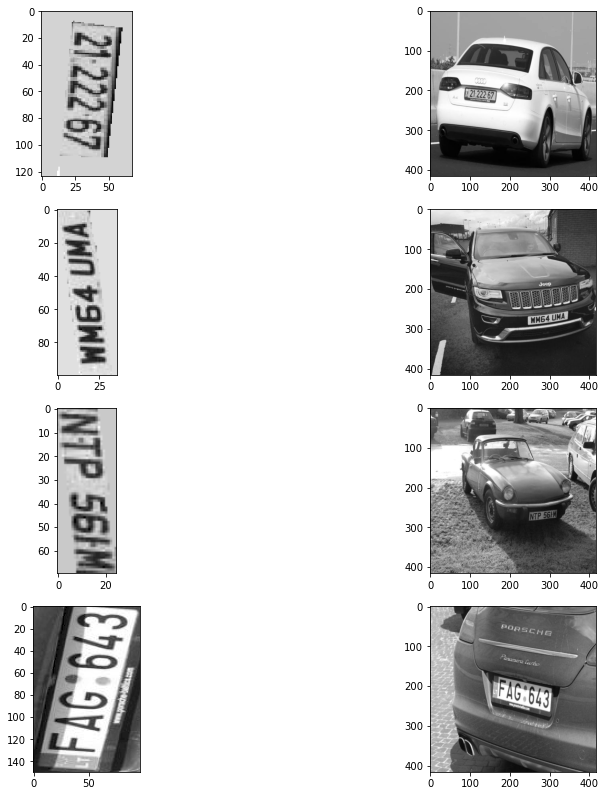

In [2]:
sift = cv2.SIFT_create() #creer l'objet sift
res = []
for filename in os.listdir("queries/"):
    if filename.endswith(".png"):
        quer = cv2.imread("queries/"+filename,0)
        kp, des = sift.detectAndCompute(quer, None)
        bf = ""
        best = 0
        for file2 in os.listdir("Done/"):
            if file2.endswith(".jpg"):
                img = cv2.imread("Done/"+file2,0)
                kpp,dess = sift.detectAndCompute(img, None)
                match = cv2.BFMatcher()
                matches = match.knnMatch(des,dess,k=2)
                
                good = []
                for m,n in matches:
                    if m.distance < 0.6*n.distance:
                        good.append(m)
                if(len(good)>best):
                    bf = str(file2)
                    best = len(good)
        res = res + [filename,bf]
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2,figsize=(14,14))
ax1.imshow(cv2.imread("queries/"+res[0],0),cmap='gray')
ax2.imshow(cv2.imread("Done/"+res[1],0),cmap='gray')
ax3.imshow(cv2.imread("queries/"+res[2],0),cmap='gray')
ax4.imshow(cv2.imread("Done/"+res[3],0),cmap='gray')
ax5.imshow(cv2.imread("queries/"+res[4],0),cmap='gray')
ax6.imshow(cv2.imread("Done/"+res[5],0),cmap='gray')
ax7.imshow(cv2.imread("queries/"+res[6],0),cmap='gray')
ax8.imshow(cv2.imread("Done/"+res[7],0),cmap='gray')

In [3]:
def findMatch(query,seuil):
    kp, des = sift.detectAndCompute(query, None)
    bf = ""
    best = 0
    for file2 in os.listdir("License Plates/"):
        if file2.endswith(".jpg"):
            img = cv2.imread("License Plates/"+file2,0)
            kpp,dess = sift.detectAndCompute(img, None)
            match = cv2.BFMatcher()
            matches = match.knnMatch(des,dess,k=2)
                
            good = []
            for m,n in matches:
                if m.distance < 0.6*n.distance:
                    good.append(m)
            if(len(good)>best):
                bf = str(file2)
                best = len(good)
    if(best>=seuil):
        print("Match found.")
        return bf
    print("No matches found.")
    return None

In [4]:
def mouseHandler(event,x,y,flags,param):
    global im_temp, pts_src
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(im_temp,(x,y),3,(0,255,255),5,cv2.LINE_AA)
        cv2.imshow("Image", im_temp)
        if len(pts_src) < 4:
            pts_src = np.append(pts_src,[(x,y)],axis=0)
            
def extractMat(image):
    global im_temp, pts_src
    im_src = cv2.imread(image)
    
    cv2.namedWindow("Image", 1)

    im_temp = im_src.copy()
    pts_src = np.empty((0,2))

    cv2.setMouseCallback("Image",mouseHandler)
    
    cv2.imshow("Image", im_temp)
    cv2.waitKey(0)
    
    return im_src[int(pts_src[:,1].min()):int(pts_src[:,1].max()),int(pts_src[:,0].min()):int(pts_src[:,0].max())]

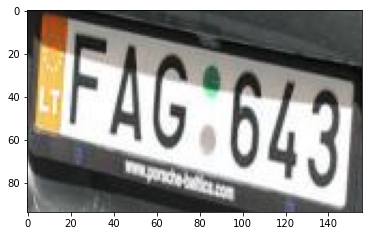

In [5]:
plt.imshow(extractMat('fg.jpg'),cmap='gray')

# La dataset train

In [6]:
train = []
ROOT = tk.Tk()
ROOT.withdraw()
for file in os.listdir("License Plates/"):
    if file.endswith(".jpg"):
        e = extractMat("License Plates/"+file)
        MAT = simpledialog.askstring(title="Test",prompt="Inserer le matricule:")
        cv2.imwrite('train/'+MAT+'.jpg',e)
ROOT.destroy()

In [7]:
def getTrain():
    train = []
    trainNames = []
    for file in os.listdir("train/"):
        if file.endswith(".jpg"):
            kp, des = sift.detectAndCompute(cv2.cvtColor(cv2.imread("train/"+file),cv2.COLOR_BGR2GRAY), None)
            train = train + [tuple(des)]
            trainNames = trainNames + [file]
    return train,trainNames

In [8]:
file = fd.askopenfilename()
if file.endswith(".jpg"):
    e = extractMat(file)
    MAT = simpledialog.askstring(title="Ajouter a train",prompt="Inserer le matricule:")
    cv2.imwrite('train/'+MAT+'.jpg',e)

In [9]:
def afficher(image,des):
    mat = cv2.imread("train/"+image)
    bf = ""
    best = 0
    for file2 in os.listdir("Done/"):
        if file2.endswith(".jpg"):
            img = cv2.imread("Done/"+file2,0)
            kpp,dess = sift.detectAndCompute(img, None)
            match = cv2.BFMatcher()
            matches = match.knnMatch(dess,des,k=2)
                
            good = []
            for m,n in matches:
                if m.distance < 0.6*n.distance:
                    good.append(m)
            
            if(len(good)>best):
                bf = str(file2)
                best = len(good)
    cv2.imshow("Matricule",mat)
    cv2.imshow("Image d'origine",cv2.imread("Done/"+bf))
    cv2.waitKey(0)

In [10]:
def fonction():
    train,tn = getTrain()
    sift = cv2.SIFT_create()
    file = fd.askopenfilename()
    if file.endswith(".jpg") or file.endswith(".png") :
        kp,dess = sift.detectAndCompute(cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2GRAY), None)
        match = cv2.BFMatcher()
        
        best = 0
        bf = 0
        for i in range(len(train)):
            des = np.array(list(train[i]))
            matches = match.knnMatch(des,dess,k=2)
                
            good = []
            for m,n in matches:
                if m.distance < 0.6*n.distance:
                    good.append(m)
            if(len(good)>best):
                bf = i
                best = len(good)
                
        if(len(train[bf])<2*best):
            messagebox.showinfo("Match found", str(best)+"/"+str(len(train[bf]))+" correspondances trouvée !")
            afficher(tn[bf],np.array(list(train[bf])))
        else:
            messagebox.showinfo("Match not found", str(best)+"/"+str(len(train[bf]))+" correspondances trouvée !")

In [11]:
fonction()